<a href="https://colab.research.google.com/github/williameclee/trade-cumulus-inversion/blob/main/invtci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trade Cumulus Inversion

## Loading of necessary libraries
The required libraries include: `numpy`, `scipy`, `matplotlib`, and custom libraries `inv` and `updateboundary`.

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from inv import *
import updateboundary

## Speficication of experiment parameters

In [3]:
# Experiment dimensions
K = 60
J = 81
Kt = K + 2
Jt = 2 * J - 1
kcp = K + 1
kcm = K - 1
jl = 60

# Physical parameters
R = 287
cp = 1004
kappa = R / cp
gr = 9.81
Ae = 6.371e06
Omega = 7.292e-05
rom = Ae * Omega

## Initialising paremeters for experiment 2

In [4]:
thetat = 320  # theta (kelvin) at model top
thetab = 300  # theta (kelvin) at model bottom
sigma0 = 45 * 100  # sigma0 (Pa/K)
pb = 1000 * 100  # pressure (Pa) at model bottom

Dp = 58 * 100  # pressure (Pa) change across inversion
theta10 = 303  # mean theta (kelvin) in inversion
dtheta = 4  # dtheta (kelvin) of inversion
thetac = 3  # thetac (kelvin) of inversion

phis = -30  # southern extent of inversion (degrees)
phin = 30  # northern extent of inversion (degrees)
phic = 0  # latitude (degrees) of inversion center

pt = pb - sigma0 * (thetat - thetab) + Dp

In [6]:
alpha = (pb - pt) / pb
beta = thetab / (thetat - thetab)
cs = alpha * R * (thetat - thetab)
eps = 4 * rom**2 / cs

## Initialising coordinates

In [7]:
# Horizontal grid
Y = np.linspace(-1, 1, 2 * J + 1)  # Potential latitude (S) in the paper
DY = Y[1] - Y[0]
phi = np.rad2deg(np.arcsin(Y))

# Vertical grid
Z = np.linspace(0, 1, K + 1)
DZ = Z[1] - Z[0]
th = np.linspace(thetab, thetat, K + 1).T
Dth = th[1] - th[0]
th_pad = np.concatenate((np.array([thetab - Dth]), th, np.array([thetat + Dth])))

YY, Th_pad = np.meshgrid(Y, th_pad, indexing="ij")
phii = np.meshgrid(phi, th_pad, indexing="ij")[0]

fac1 = eps * DY * Y
fac2 = 2 * DY * DZ**2
f1 = fac1 * (1 - Y**2)

## Initialising variables for experiment 2

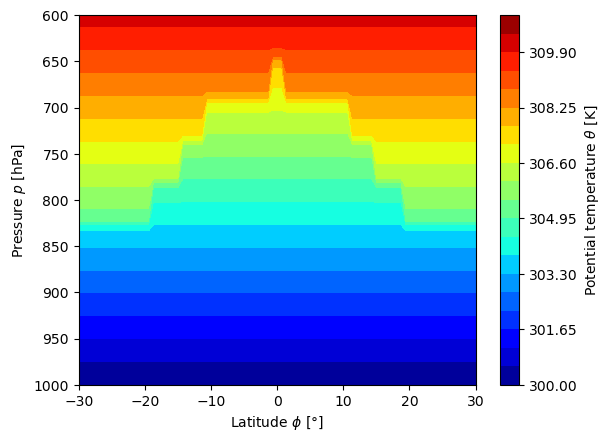

In [22]:
# Theta
phi_N = (phi <= phin) & (phi > phic)
phi_S = (phi >= phis) & (phi < phic)
phi_C = phi == phic
theta1 = np.full((2 * J + 1), theta10)

theta1[phi_N] = theta10 + dtheta * fexp((phin - phi[phi_N]) / (phin - phic))
theta1[phi_S] = theta10 + dtheta * fexp((phi[phi_S] - phis) / (phic - phis))
theta1[phi_C] = theta10 + dtheta
theta2 = theta1 + thetac

#  Pressure
th1_grid = np.meshgrid(theta1, th_pad, indexing="ij")[0]
th2_grid = np.meshgrid(theta2, th_pad, indexing="ij")[0]
th_T = Th_pad >= th2_grid
th_C = (Th_pad > th1_grid) & (Th_pad < th2_grid)
Pres = pb - sigma0 * (Th_pad - thetab)
Pres[th_T] = Pres[th_T] + Dp
Pres[th_C] = Pres[th_C] + Dp * fexp((Th_pad[th_C] - th1_grid[th_C]) / thetac)
Pres = Pres / pb
pref = np.zeros([1, Kt])
for k in range(Kt):
    pref[0, k] = pmean(Pres[:, k], Y)
Gamma = Pres**(kappa - 1)

In [ ]:
# plot
fig, ax = plt.subplots()
contourf_p = ax.contourf(phii, Pres * pb / 100, Th_pad, levels=np.linspace(300, 311, 21), cmap="jet")
ax.set_xlim(-30, 30)
ax.set_ylim(1000, 600)
ax.set_xlabel(r"Latitude $\phi$ [°]")
ax.set_ylabel(r"Pressure $p$ [hPa]")
fig.colorbar(contourf_p, label=r"Potential temperature $\theta$ [K]")
plt.show()

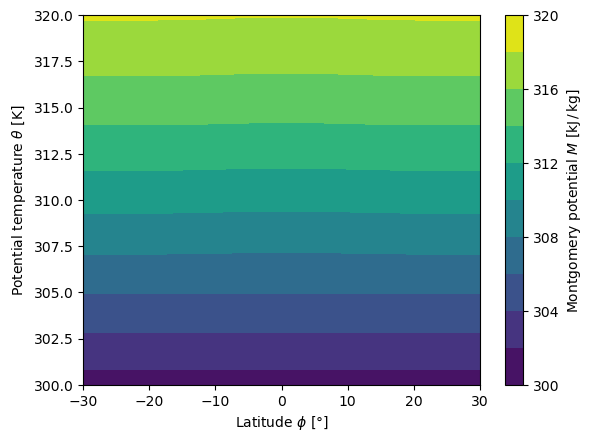

In [19]:
# compute initial m field at even points
# the M (Montgomery potential) is normalised by a factor of cs
x = np.zeros((2 * J - 1, kcp + 2))  # (-jc+1:jc-1,-1:kcp)
xtmp = np.zeros(K + 1)  # (0:kc)
ftmp = np.zeros(K + 1)  # (0:kc)

method = 1
x[:, 1] = cp * thetab / cs
for j in range(0, 2 * J - 1, 2):
    ftmp = pres[j, :] ** kappa / (kappa * alpha)
    xtmp = intdde(method, K, DZ, x[j, 0], ftmp)
    x[j, 1:-1] = xtmp
    x[j, 0] = x[j, 2] - tdz * x[j, 0] / beta
    x[j, -1] = x[j, -3] + tdz * (1 - alpha) ** kappa / (kappa * alpha)

# initialise x (i.e., sin(phi)) at odd points
x[1:-1:2, :] = np.tile(Y[2:-2:2], (kcp + 2, 1)).T


# Visualise x
fig, ax = plt.subplots()
contourf_M = ax.contourf(phi[1:-1:2], th, x[::2, 1:-1].T * cs / 1000, levels=10)
ax.set_xlim(-30, 30)
ax.set_ylim(300, 320)
ax.set_xlabel(r"Latitude $\phi$ [°]")
ax.set_ylabel(r"Potential temperature $\theta$ [K]")
fig.colorbar(
    contourf_M, label=r"Montgomery potential $M$ [$\mathrm{kJ}\,/\,\mathrm{kg}$]"
)
plt.show()

## Compute Sigma

/var/folders/bm/k1ffy7j930jdkxs326mj3pt80000gn/T/ipykernel_6302/882863195.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


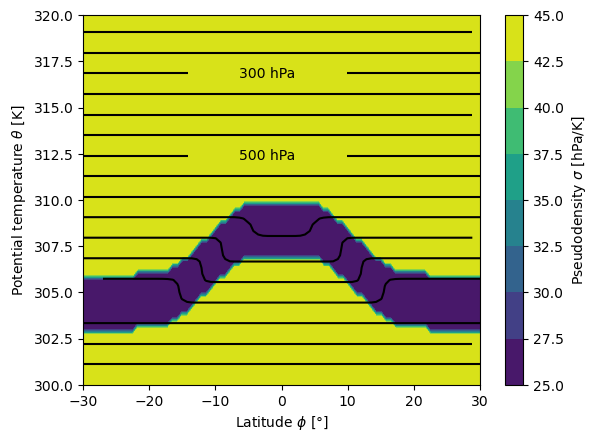

In [20]:
tinc = 0.1
sigma = np.zeros((2 * J + 1, K + 1))  # (-jc:jc,0:kc)
lat = np.zeros(2 * jl + 1)  # (-jl:jl)

# Calculate sigma values
sigma[theta_T | theta_B] = 1
for k in range(K + 1):
    for j in range(2 * J + 1):
        if th[k] < theta2[j] and th[k] >= theta1[j]:
            tp = th[k] + tinc
            tm = th[k] - tinc
            fp = (tp - theta1[j]) / (theta2[j] - theta1[j])
            fm = (tm - theta1[j]) / (theta2[j] - theta1[j])
            dfdt = (fp - fm) / (2 * tinc)
            sigma[j, k] = (sigma0 - Dp * dfdt) / sigma0

phimin = -30  # phimin (degrees) for plot
phimax = 30  # phi max (degrees) for plot
ptop = 300  # ptop (hPa) for plot

# interpolate potential latitude and theta postions to actual latitude
lat = np.linspace(phimin, phimax, 2 * jl + 1)
dl = lat[1] - lat[0]

# ignoring line 255 of calling int

# Visualise sigma
fig, ax = plt.subplots()
contourf_sigma = ax.contourf(phi, th, sigma.T * sigma0 / 100)
contour_pres = ax.contour(
    phi, th, pres.T * pb / 100, colors="k", levels=np.arange(100, 1000, 50)
)
ax.clabel(contour_pres, levels=np.arange(100, 1000, 100), fmt="%d hPa")
ax.set_xlim(-30, 30)
ax.set_ylim(300, 320)
fig.colorbar(contourf_sigma, label=r"Pseudodensity $\sigma$ [hPa/K]")
ax.set_xlabel(r"Latitude $\phi$ [°]")
ax.set_ylabel(r"Potential temperature $\theta$ [K]")
fig.show()

plt.plot(lat)
plt.show()

## Iteration

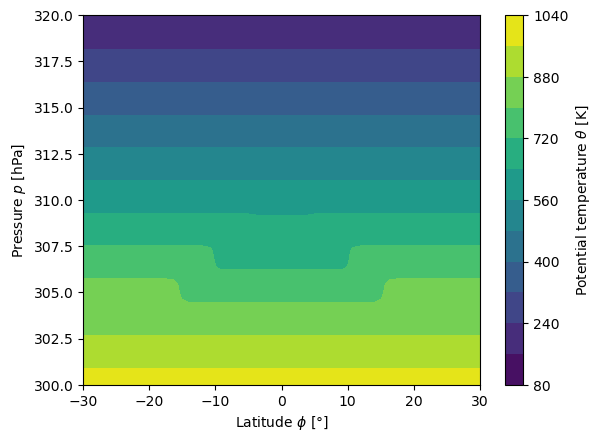

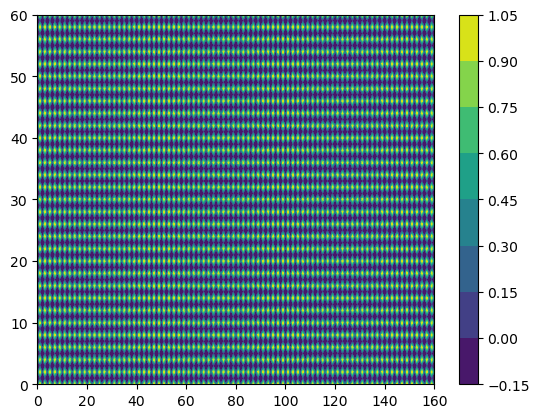

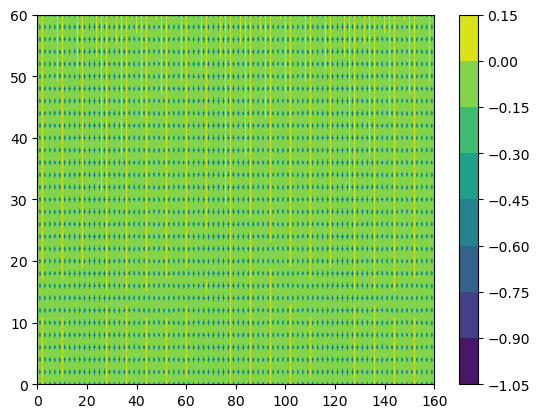

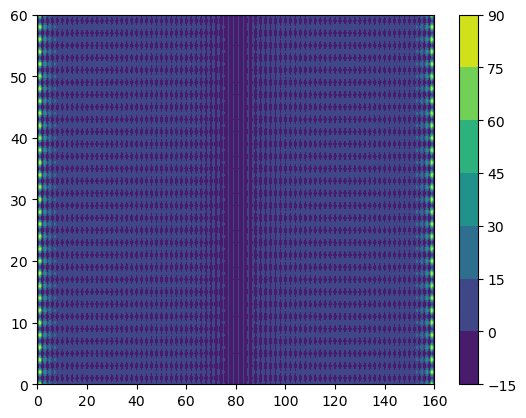

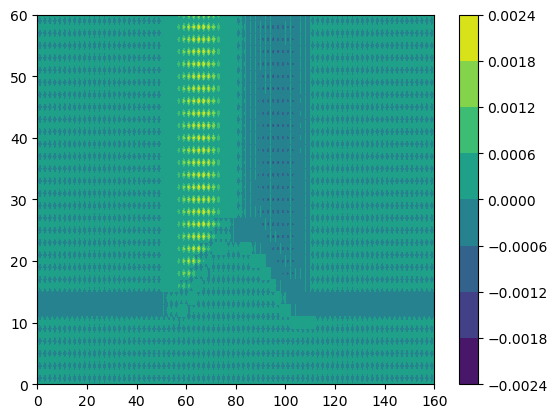

/Users/williewillow/Documents/COLLEGE/2023Summer/trade-cumulus-inversion/inv.py:81: RuntimeWarning: invalid value encountered in divide
  B[k,:] = B[k,:] / D[k-1,:]
/Users/williewillow/Documents/COLLEGE/2023Summer/trade-cumulus-inversion/updateboundary.py:57: RuntimeWarning: invalid value encountered in power
  pres[1:-1:2, :] = (alpha * kappa * (x[::2, 2:] - x[::2, :-2]) / tdz) ** (1 / kappa)
/Users/williewillow/Documents/COLLEGE/2023Summer/trade-cumulus-inversion/updateboundary.py:69: RuntimeWarning: overflow encountered in multiply
  avep[k] = np.sum(pres[1:-1:2, k] * (xp - xm)) / 2
/opt/anaconda3/envs/geo/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/williewillow/Documents/COLLEGE/2023Summer/trade-cumulus-inversion/updateboundary.py:70: RuntimeWarning: invalid value encountered in power
  gamma[1:-1:2, :] = pres[1:-1:2, :] ** (kappa - 1)


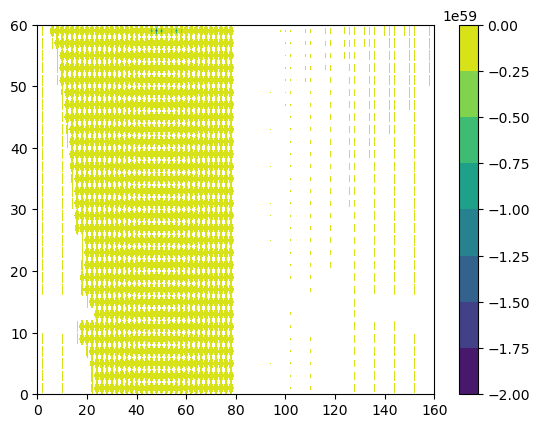

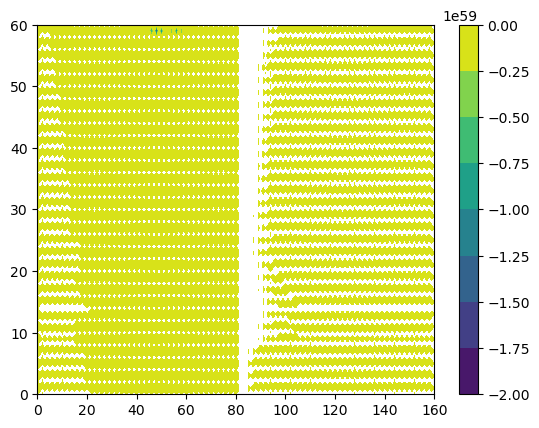

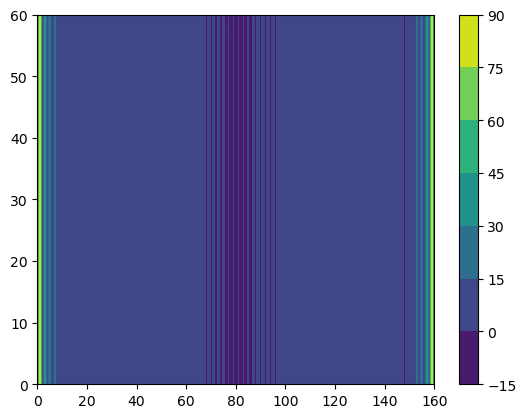

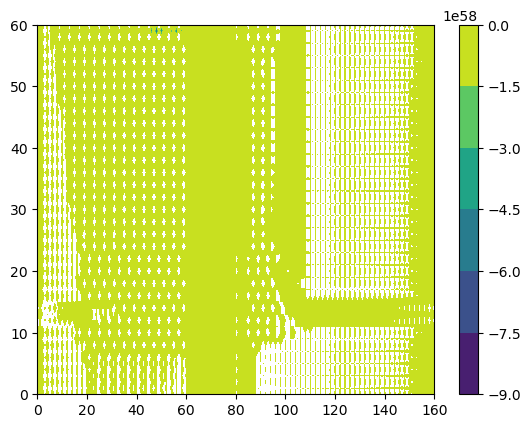

/Users/williewillow/Documents/COLLEGE/2023Summer/trade-cumulus-inversion/inv.py:90: RuntimeWarning: overflow encountered in multiply
  X[k,:] = X[k,:] - B[k,:] * X[k-1,:]
/Users/williewillow/Documents/COLLEGE/2023Summer/trade-cumulus-inversion/inv.py:90: RuntimeWarning: invalid value encountered in multiply
  X[k,:] = X[k,:] - B[k,:] * X[k-1,:]


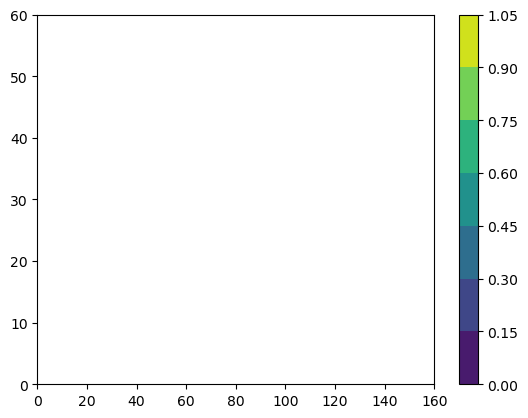

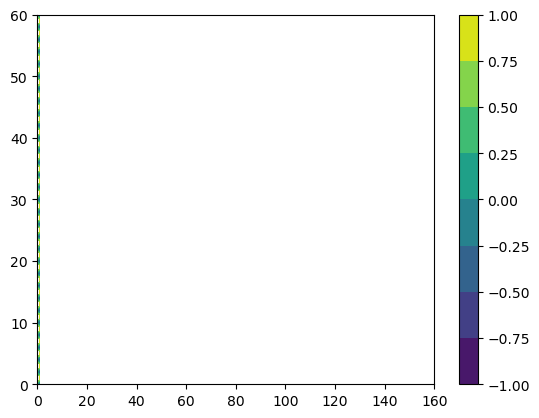

/opt/anaconda3/envs/geo/lib/python3.10/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/opt/anaconda3/envs/geo/lib/python3.10/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


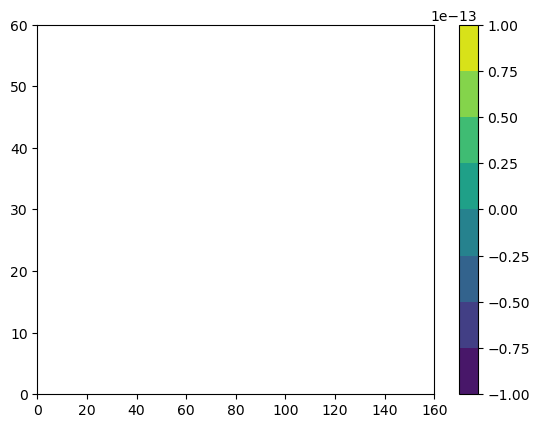

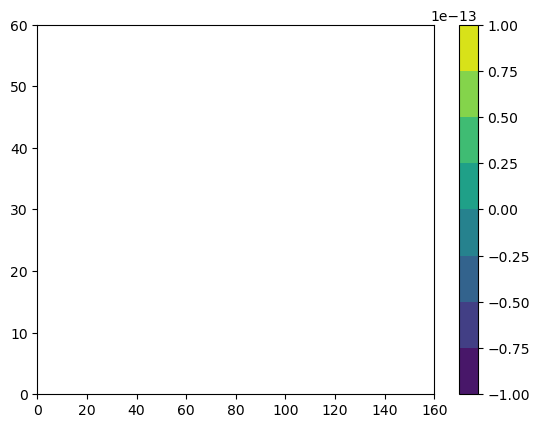

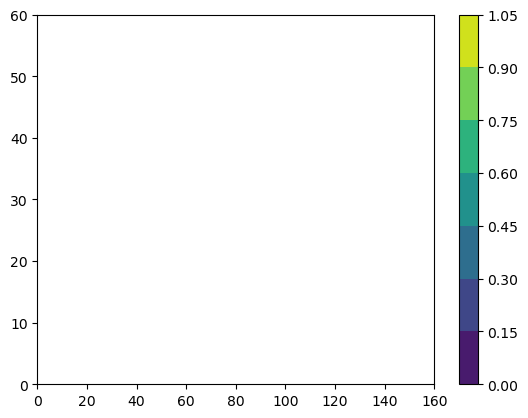

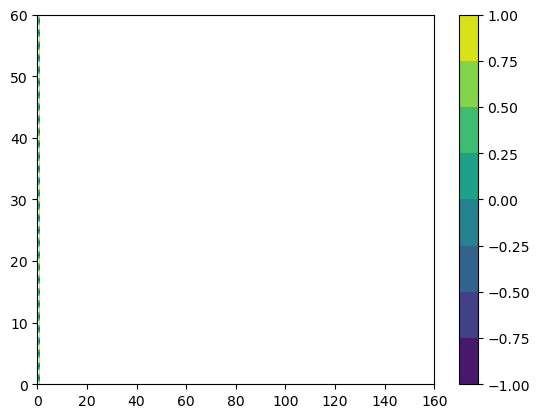

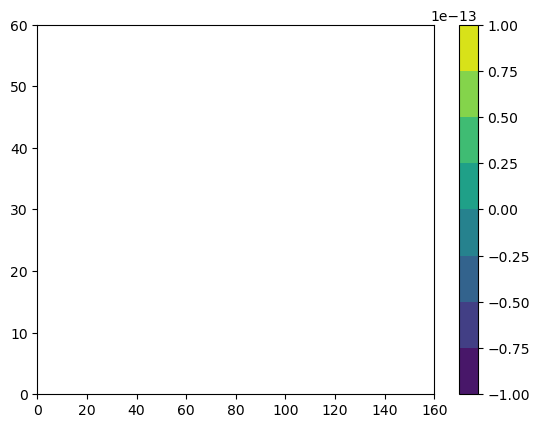

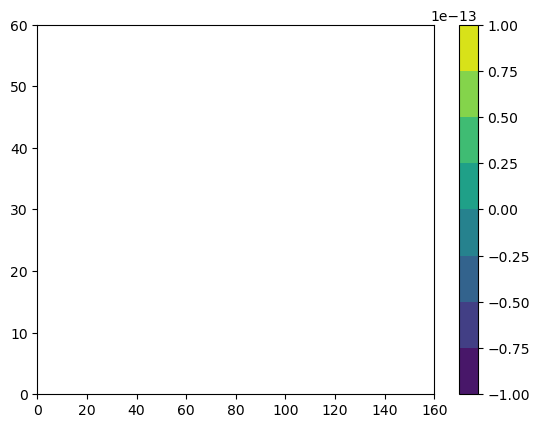

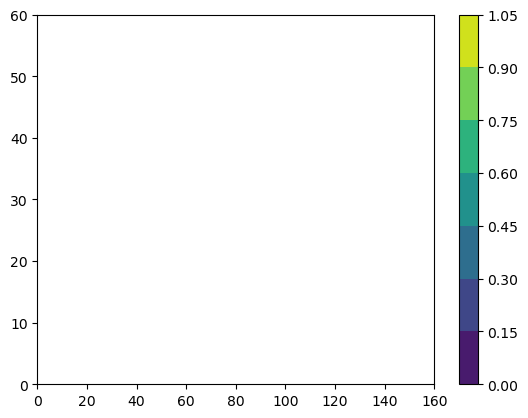

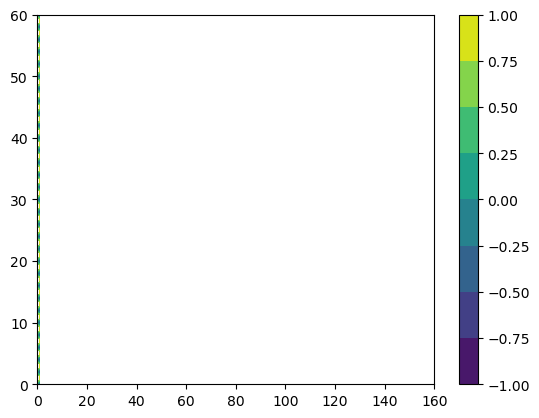

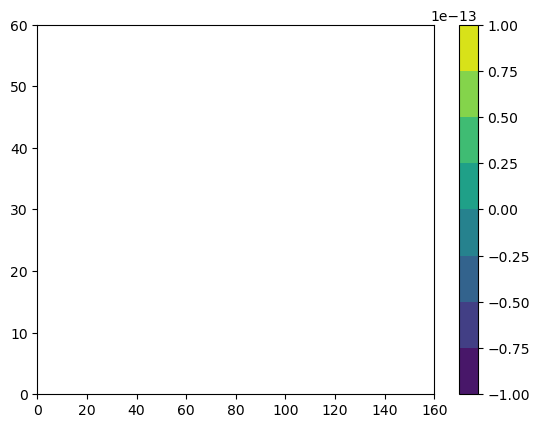

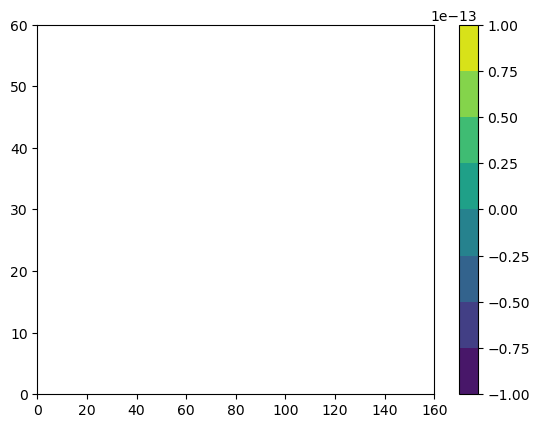

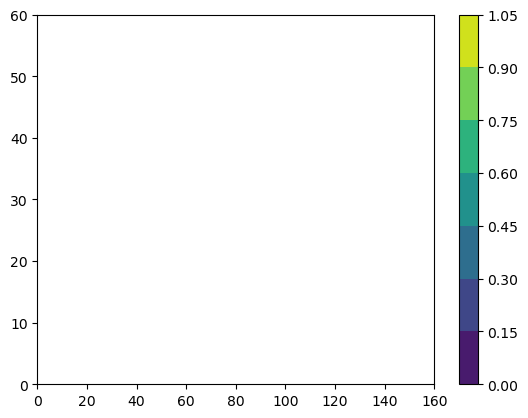

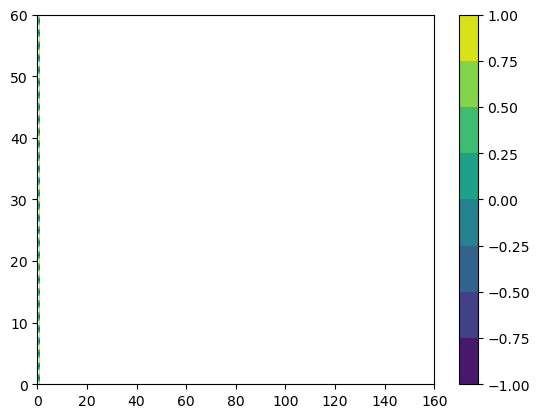

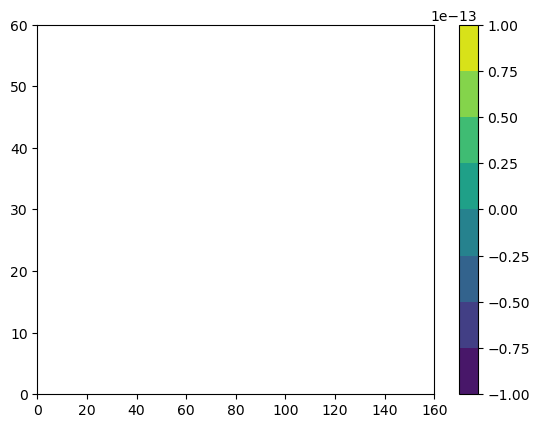

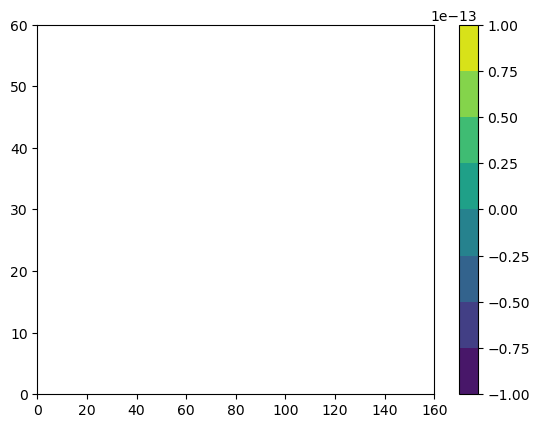

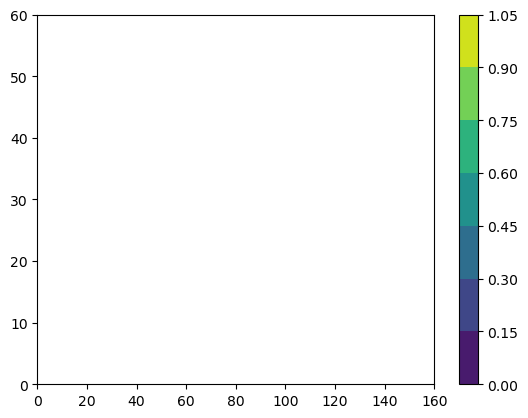

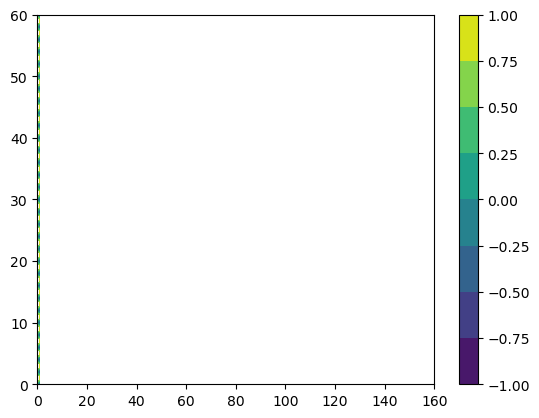

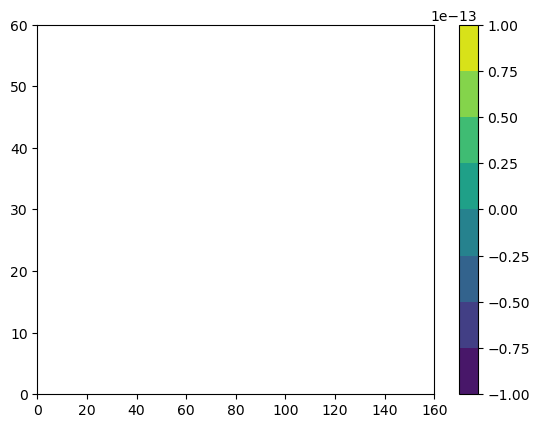

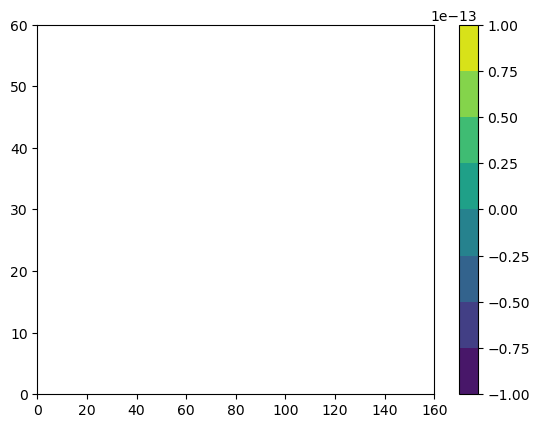

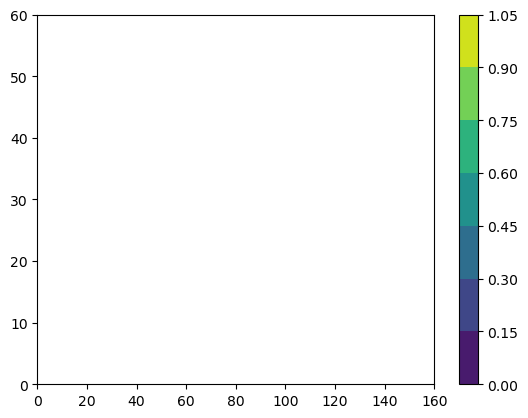

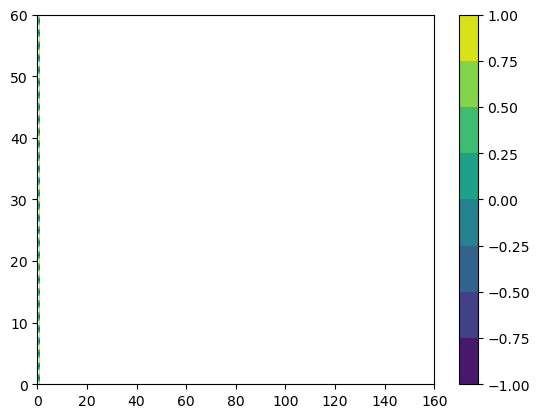

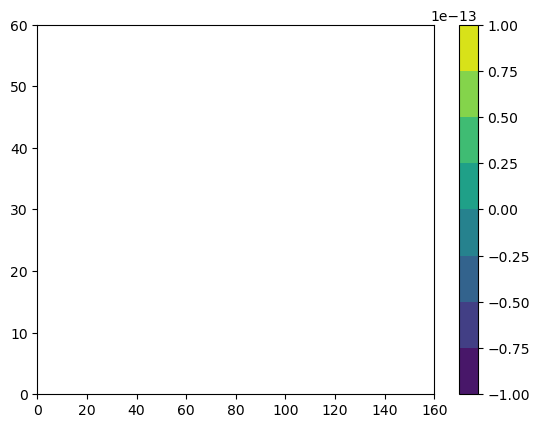

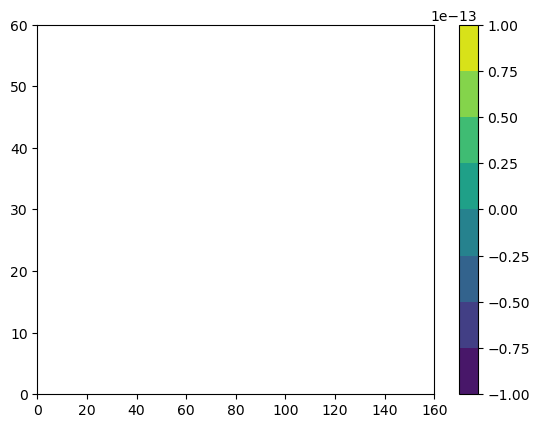

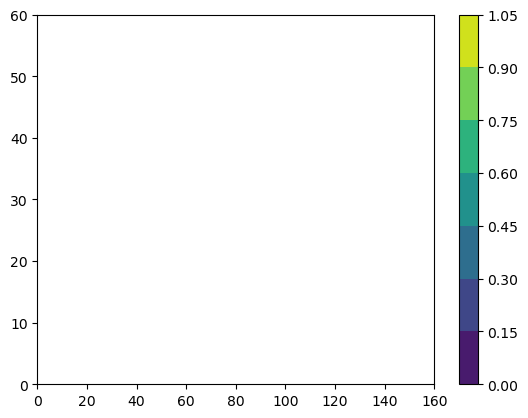

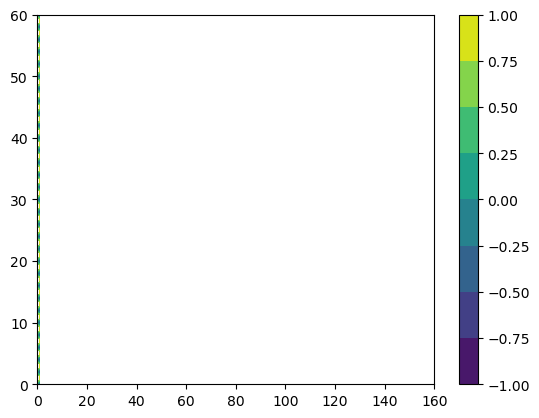

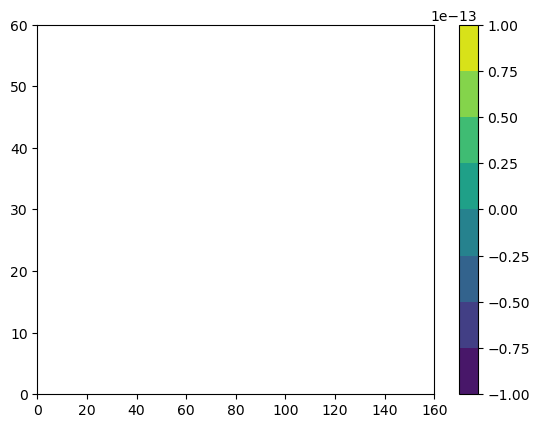

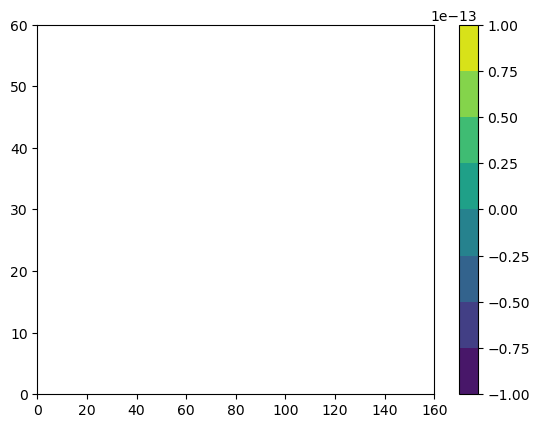

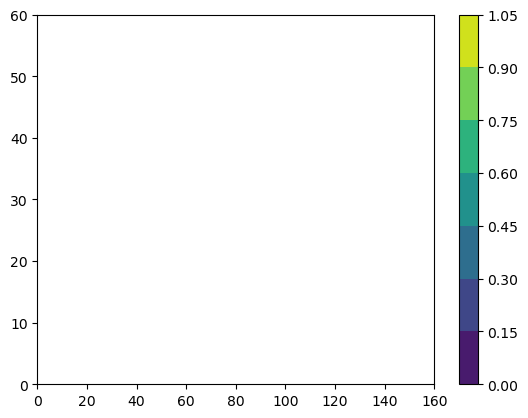

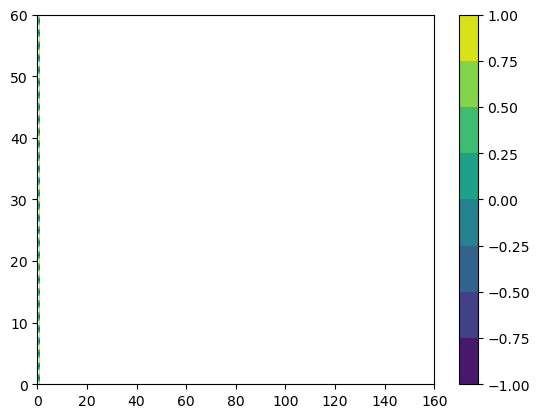

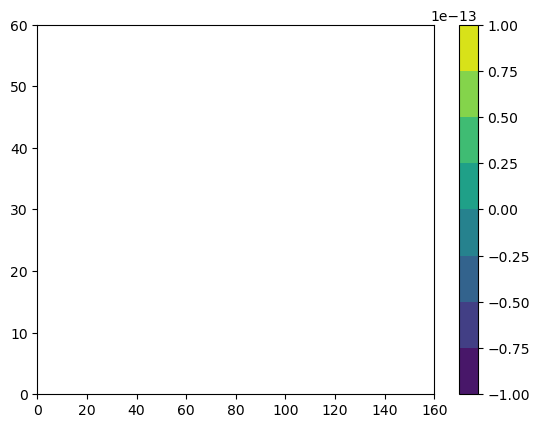

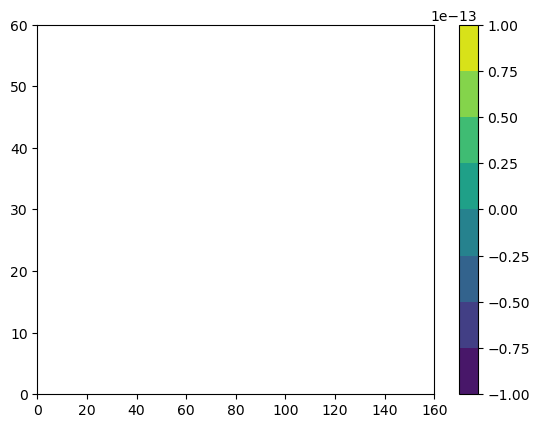

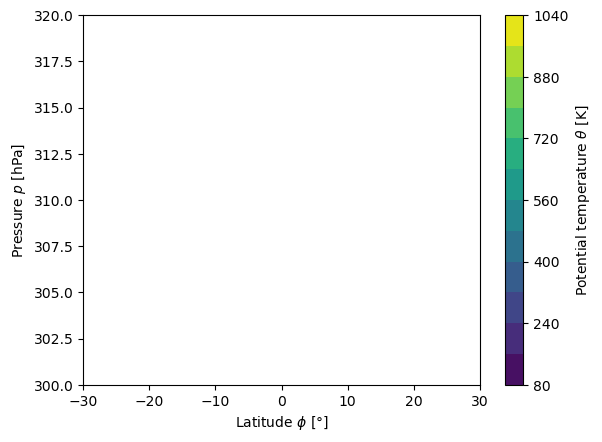

In [21]:
fig, ax = plt.subplots()
contourf_p = ax.contourf(phi, th, pres.T * pb / 100, levels=10)
ax.set_xlim(-30, 30)
# ax.set_ylim(1000, 600)
ax.set_xlabel(r"Latitude $\phi$ [°]")
ax.set_ylabel(r"Pressure $p$ [hPa]")
fig.colorbar(contourf_p, label=r"Potential temperature $\theta$ [K]")
plt.show()

nmax = 10  # maximum number of iteration sweeps
niter = 1  # number of Newton iterations per sweep
nup = 10  # print out the residual norm every nup iterations

u = np.zeros((2 * J - 1, K + 1))  # (-jc+1:jc-1,0:kc)
d = np.zeros((2 * J - 1, K + 1))  # (-jc+1:jc-1,0:kc)
g = np.zeros((2 * J - 1, K + 1))  # (-jc+1:jc-1,0:kc)
l = np.zeros((2 * J - 1, K + 1))  # (-jc+1:jc-1,0:kc)

n = 0
while n < nmax:
    n = n + 1
    rn = 0
    # Zebra relaxation in horizontal direction
    # first relax even horizontal lines, then odd lines
    for ks in range(2):
        iter = 0
        while iter < niter:
            iter = iter + 1
            for k in range(ks, K + 1, 2):
                kx = k + 1

                # fill in matrix elements for even points
                # point adjacent to south pole
                # using sin(phi)=sin(Phi)=-1 for boundary condition at south pole
                dxds = x[1, kx] + 1
                dxdz2 = x[0, kx + 1] - 2 * x[0, kx] + x[0, kx - 1]
                f2 = x[1, kx] - 1
                f3 = 1 - (f2 / 2) ** 2
                f4 = ((x[1, kx + 1] - x[1, kx - 1]) / 4) ** 2
                term2 = f1[0 + 1] * f4 * (1 + 3 * (f2 / 2) ** 2) / (f3**3)
                u[0, k] = dxdz2 + term2
                d[0, k] = -2 * dxds
                g[0, k] = -(
                    dxds * dxdz2
                    + f1[0 + 1] * f2 * f4 / f3**2
                    + gamma[0, k] * sigma[0, k] * fac2
                )
                # point adjacent to north pole
                # using sin(phi)=sin(Phi)=1 for boundary condition at south pole
                dxds = 1 - x[-2, kx]
                dxdz2 = x[-1, kx + 1] - 2 * x[-1, kx] + x[-1, kx - 1]
                f2 = 1 + x[-2, kx]
                f3 = 1 - (f2 / 2) ** 2
                f4 = ((x[-2, kx + 1] - x[-2, kx - 1]) / 4) ** 2
                term2 = f1[-1 - 1] * f4 * (1 + 3 * (f2 / 2) ** 2) / (f3**3)
                d[-1, k] = -2 * dxds
                l[-1, k] = -dxdz2 + term2
                g[-1, k] = -(
                    dxds * dxdz2
                    + f1[-1 - 1] * f2 * f4 / f3**2
                    + gamma[-1, k] * sigma[-1, k] * fac2
                )
                for j in range(2, 2 * J - 2, 2):
                    dxds = x[j + 1, kx] - x[j - 1, kx]
                    dxdz2 = x[j, kx + 1] - 2 * x[j, kx] + x[j, kx - 1]
                    f2 = x[j + 1, kx] + x[j - 1, kx]
                    f3 = 1 - (f2 / 2) ** 2
                    f4 = (
                        (
                            x[j + 1, kx + 1]
                            + x[j - 1, kx + 1]
                            - x[j + 1, kx - 1]
                            - x[j - 1, kx - 1]
                        )
                        / 4
                    ) ** 2
                    term2 = f1[j + 1] * f4 * (1 + 3 * (f2 / 2) ** 2) / (f3**3)
                    u[j, k] = dxdz2 + term2
                    d[j, k] = -2 * dxds
                    l[j, k] = -dxdz2 + term2
                    g[j, k] = -(
                        dxds * dxdz2
                        + f1[j + 1] * f2 * f4 / (f3**2)
                        + gamma[j, k] * sigma[j, k] * fac2
                    )
                # fill in matrix elements for odd points
                for j in range(1, 2 * J - 1, 2):
                    xjs = x[j, kx] * x[j, kx]
                    fj = xjs - scs[j + 1]
                    dj = 1 - xjs
                    l[j, k] = -1
                    d[j, k] = fac1[j + 1] * (
                        2 * x[j, kx] * (1 - scs[j + 1]) / (dj**2)
                    )
                    u[j, k] = 1
                    g[j, k] = -(fac1[j + 1] * (fj / dj) + x[j + 1, kx] - x[j - 1, kx])
            if iter == 1 & n == 1:
                plt.contourf(u.T)
                plt.colorbar()
                plt.show()
                plt.contourf(l.T)
                plt.colorbar()
                plt.show()
                plt.contourf(d.T)
                plt.colorbar()
                plt.show()
                plt.contourf(g.T)
                plt.colorbar()
                plt.show()

            u, d, l = gtdmsf(l, d, u)
            g = gtdmss(l, d, u, g)

            x[:, ks + 1 : K + 2 : 2] = (
                x[:, ks + 1 : K + 2 : 2] + g[:, ks : K + 1 : 2]
            )

        # update boundary
        x[::2, -1], x[::2, 0] = updateboundary.m_boundary(
            x, scs, DZ, tdz, alpha, beta, eps, kappa
        )
        x[1::2, -1], x[1::2, 0] = updateboundary.s_boundary(x, fac1, scs)
        # Find gamma for general case
        pres[1:-1:2, :], gamma[1:-1:2, :], avep, dif = updateboundary.gamma_correction(
            pres, gamma, x, K, refp, kappa, alpha, tdz
        )
        # compute a corrected m field
        x[::2, :] = updateboundary.m_correction(
            x, pres, J, K, DZ, tdz, alpha, beta, eps, kappa, scs
        )

fig, ax = plt.subplots()
contourf_p = ax.contourf(phi, th, pres.T * pb / 100, levels=10)
ax.set_xlim(-30, 30)
# ax.set_ylim(1000, 600)
ax.set_xlabel(r"Latitude $\phi$ [°]")
ax.set_ylabel(r"Pressure $p$ [hPa]")
fig.colorbar(contourf_p, label=r"Potential temperature $\theta$ [K]")
plt.show()